In [1]:
from utils.analysis.tools import simDir, periodicity_plot
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm

In [2]:
from utils import plot

In [ ]:
class periodicityPhaseDiagram:
    def __init__(self,
                 directory: str,
                 sweep_file: str = "sweep_parameters.txt"):
        self.sweep_directory = Path(directory)
        self.sweep_file = self.sweep_directory / sweep_file
        self.sweep_parameters = [line.split(",")[0] for line in self.sweep_file.read_text().splitlines()]

    def extract_data(self):
        simdir_paths = [file.parent for file in self.sweep_directory.glob("./*/input_params.txt")]
        processes = mp.Pool(8-1)
        self.results = tqdm(processes.imap(self.worker,simdir_paths),total=len(simdir_paths))
        self.df = pd.DataFrame(self.results)
    
    def worker(self,worker_input):
        simdir_path = worker_input
        sim = simDir(simdir_path)
        param_values = sim.params
        relevant_params = {parameter: str(param_values[parameter]) for parameter in self.sweep_parameters}
        sim.run()
        sim.rna()
        sim.condensate()
        sim.periodicity(15000)
        period = np.diff(sim.time[sim.peaks],axis=0).mean()
        shortest = np.min([sim.peaks.shape,sim.troughs.shape])
        peaks = sim.peaks[:shortest]
        troughs = sim.troughs[:shortest]
        com_height = np.abs(sim.com[peaks,0]-sim.com[troughs,0]).mean()
        radius_variance_height = np.abs(sim.radius_variance[peaks]-sim.radius_variance[troughs]).mean()
        eccentricity_height = np.abs(sim.eccentricity[peaks]-sim.eccentricity[troughs]).mean()
        rna_height = np.abs(sim.rna_amount[peaks]-sim.rna_amount[troughs]).mean()
        if troughs.size == 0 or peaks.size == 0:
            return relevant_params | {"period": period,
                                  "com_height": com_height,
                                  "radius_variance_height": radius_variance_height,
                                  "eccentricity_height": eccentricity_height,
                                  "rna_height": rna_height,
                                  "xy_trough_end": np.nan,
                                  "xy_peak_end": np.nan,
                                  "c_trough_end": np.nan,
                                  "c_peak_end": np.nan}
        else:
            xy_trough_end = sim.xy[sim.mask[troughs[-1],:]]
            c_trough_end = sim.concentration_profile[0][troughs[-1],:][sim.mask[troughs[-1],:]]
            xy_peak_end = sim.xy[sim.mask[peaks[-1],:]]
            c_peak_end = sim.concentration_profile[0][peaks[-1],:][sim.mask[peaks[-1],:]]
            return relevant_params | {"period": period,
                                    "com_height": com_height,
                                    "radius_variance_height": radius_variance_height,
                                    "eccentricity_height": eccentricity_height,
                                    "rna_height": rna_height,
                                    "xy_trough_end": xy_trough_end,
                                    "xy_peak_end": xy_peak_end,
                                    "c_trough_end": c_trough_end,
                                    "c_peak_end": c_peak_end}

In [ ]:
ppd = periodicityPhaseDiagram("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_TimeDelay/20240223_PhaseDiagramHillFaster")

In [ ]:
ppd.extract_data()

In [ ]:
ppd.df.to_pickle("20240223_PhaseDiagramHillFaster.pkl")

In [32]:
df = pd.read_pickle("20240223_PhaseDiagramHillFaster.pkl")

In [33]:
df["tau"] = df["tau"].astype(np.float64)
df["chiPR_tilde"] = df["chiPR_tilde"].astype(np.float64)
df["rna_height"] = df["rna_height"].astype(np.float64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


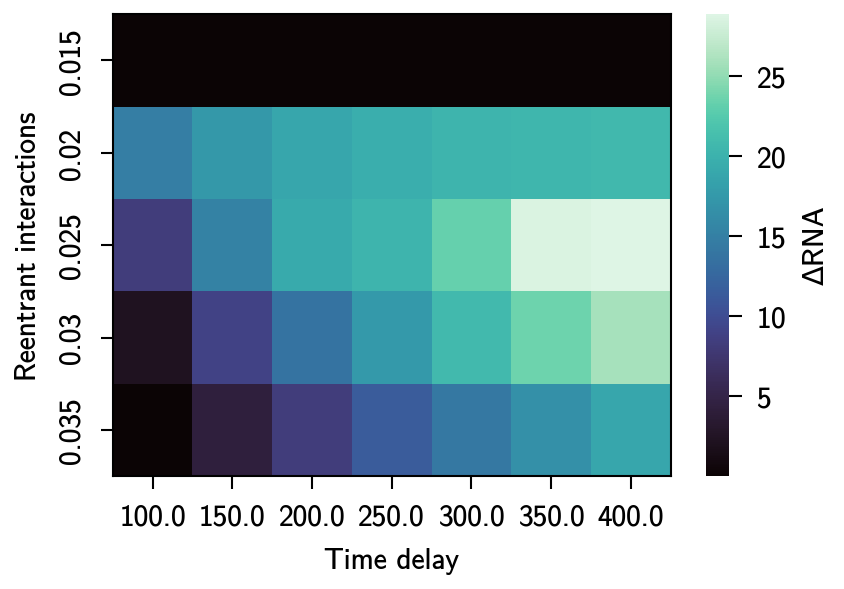

In [7]:
variable = "rna_height"
rna_pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable)
xlabel = "Time delay"
ylabel = "Reentrant interactions"
fig, ax = plt.subplots()
sns.heatmap(rna_pivot,cmap="mako",ax=ax,cbar_kws={"label":r"$\Delta$RNA"})
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


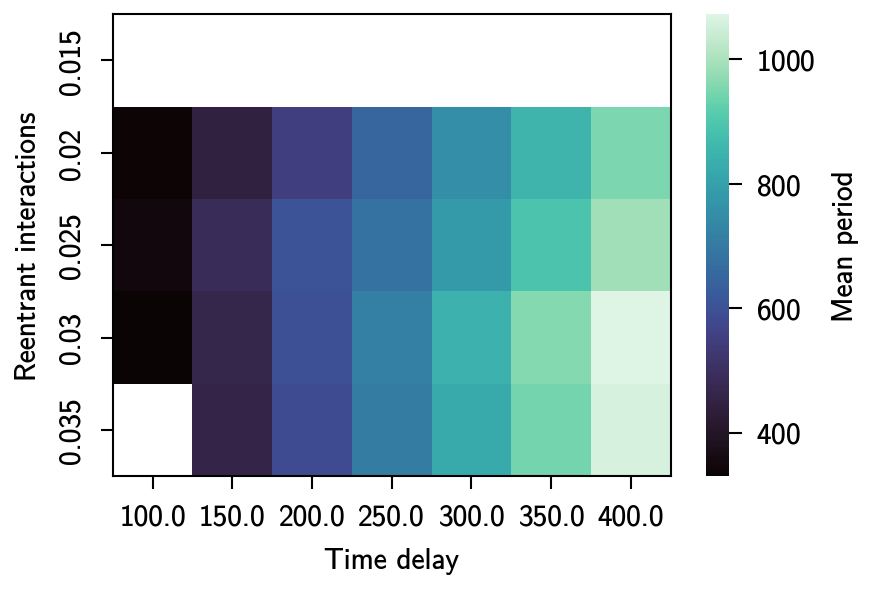

In [31]:
variable = "period"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable)
pivot[rna_pivot<2] = np.nan
xlabel = "Time delay"
ylabel = "Reentrant interactions"
fig, ax = plt.subplots()
sns.heatmap(pivot,cmap="mako",ax=ax,cbar_kws={"label":"Mean period"})
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

In [17]:
df.columns

Index(['tau', 'chiPR_tilde', 'period', 'com_height', 'radius_variance_height',
       'eccentricity_height', 'rna_height', 'xy_trough_end', 'xy_peak_end',
       'c_trough_end', 'c_peak_end'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


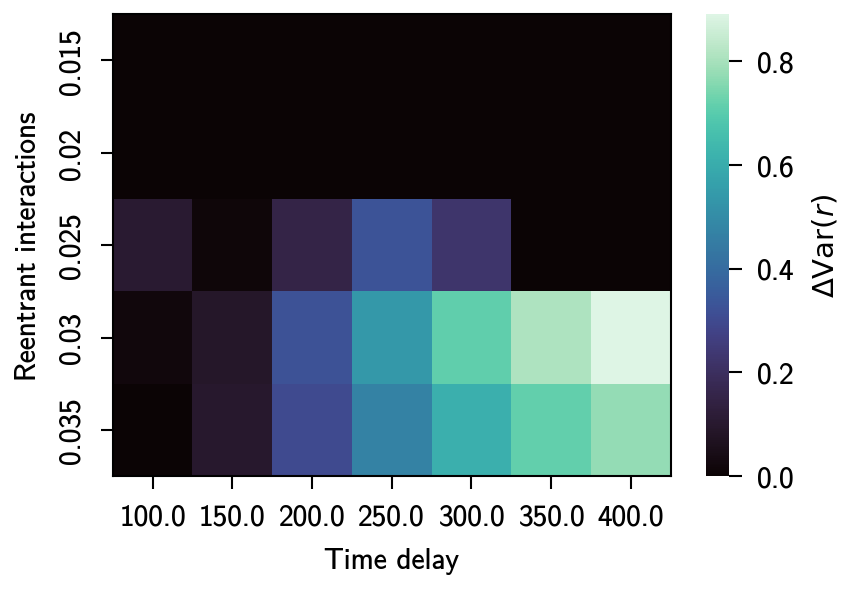

In [18]:
variable = "radius_variance_height"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable)
xlabel = "Time delay"
ylabel = "Reentrant interactions"
fig, ax = plt.subplots()
sns.heatmap(pivot,cmap="mako",ax=ax,cbar_kws={"label":r"$\Delta \mathrm{Var}(r)$"})
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


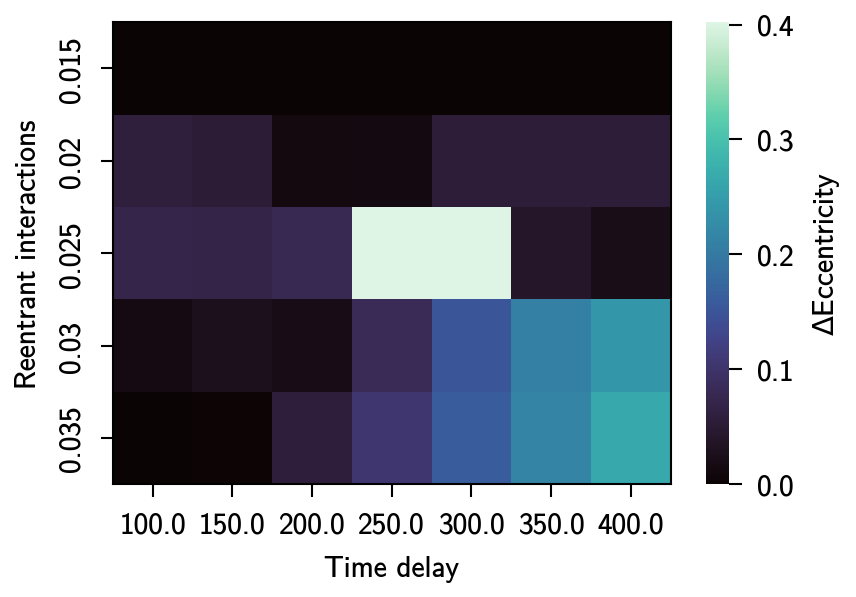

In [19]:
variable = "eccentricity_height"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable)
xlabel = "Time delay"
ylabel = "Reentrant interactions"
fig, ax = plt.subplots()
sns.heatmap(pivot,cmap="mako",ax=ax,cbar_kws={"label":r"$\Delta$Eccentricity"})
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


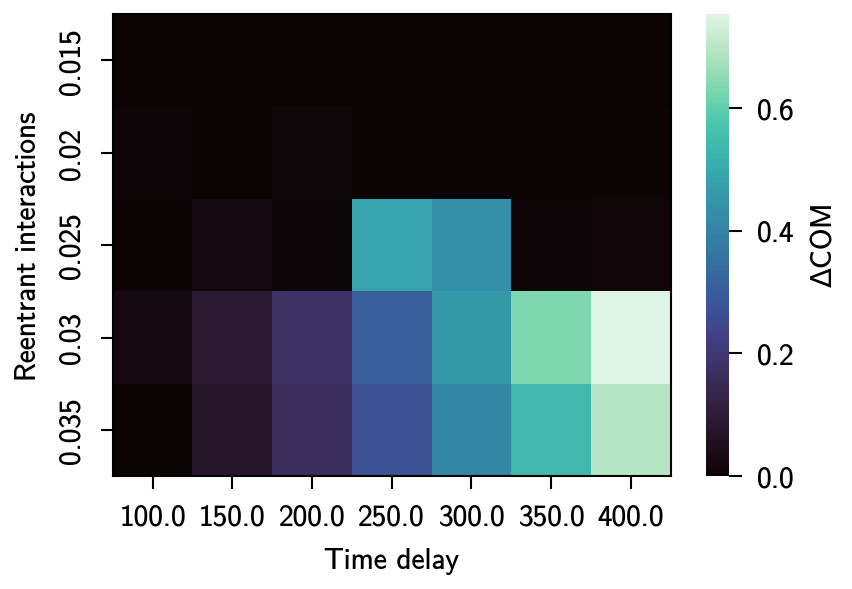

In [20]:
variable = "com_height"
pivot = df.pivot_table(index="chiPR_tilde",columns="tau",values=variable)
xlabel = "Time delay"
ylabel = "Reentrant interactions"
fig, ax = plt.subplots()
sns.heatmap(pivot,cmap="mako",ax=ax,cbar_kws={"label":r"$\Delta$COM"})
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.legend()
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

In [21]:
df.loc[df["period"]<200,"period"] = np.nan

Text(0.5, 0, 'Tau')

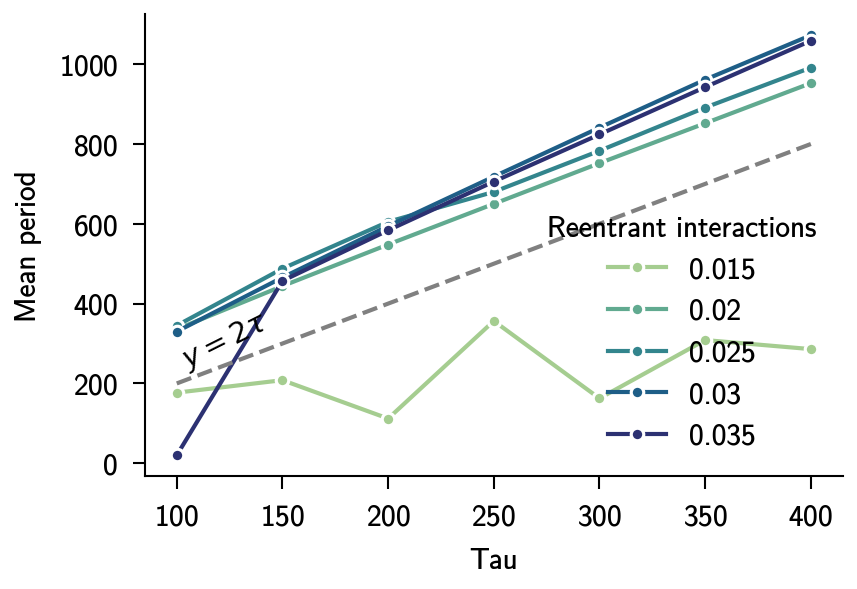

In [34]:
fig, ax = plt.subplots()
sns.lineplot(df,x="tau",y="period",hue="chiPR_tilde",palette="crest",
             marker="o",legend="full",ax=ax)
taus = np.arange(100,450,50)
ax.plot(taus,2*taus,color="grey",linestyle="--",)
ax.annotate(text=r"$y=2\tau$",xy=(100,240),rotation=np.rad2deg(np.arctan(1/2)))
ax.legend(title="Reentrant interactions")
ax.set_ylabel("Mean period")
ax.set_xlabel("Tau")

In [23]:
df

,tau,chiPR_tilde,period,com_height,radius_variance_height,eccentricity_height,rna_height,xy_trough_end,xy_peak_end,c_trough_end,c_peak_end
0,100.0,0.030,329.999939,2.111854e-02,2.064712e-02,0.015285,2.146594e+00,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.5170074, 4.5096173, 4.519285, 4.5179763, 4....","[4.5202823, 4.5141935, 4.5229936, 4.521405, 4...."
1,150.0,0.015,208.181778,1.200640e-11,1.112708e-13,0.000000,9.725241e-09,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.2169166, 4.3518453, 4.176391, 4.046835, 4.0...","[4.2169166, 4.3518453, 4.176391, 4.046835, 4.0..."
2,150.0,0.020,443.999908,1.692764e-03,1.097314e-04,0.052406,1.742947e+01,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.0872407, 4.247791, 4.0436153, 4.482401, 4.2...","[4.3342047, 4.424789, 4.304389, 4.1997705, 4.1..."
3,100.0,0.035,NaN,5.871083e-10,7.675571e-11,0.000000,5.437119e-08,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.5135074, 4.4824967, 4.5218115, 4.5165114, 4...","[4.5135074, 4.4824967, 4.5218115, 4.5165114, 4..."
4,100.0,0.020,335.714203,6.046518e-03,2.004277e-04,0.059499,1.480998e+01,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.209374, 4.3348646, 4.1715455, 4.049836, 4.0...","[4.2708626, 4.387163, 4.234485, 4.1135774, 4.0..."
5,100.0,0.015,NaN,1.534150e-11,1.421793e-13,0.000000,1.243048e-08,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.2169166, 4.3518453, 4.176391, 4.046835, 4.0...","[4.2169166, 4.3518453, 4.176391, 4.046835, 4.0..."
6,100.0,0.025,344.999939,3.792642e-03,1.052018e-01,0.072041,8.249651e+00,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.5154347, 4.5143127, 4.5038137, 4.5156007, 4...","[4.525027, 4.5227704, 4.516961, 4.52605, 4.525..."
7,200.0,0.020,548.124878,1.157980e-02,1.946112e-04,0.011709,1.884824e+01,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.0747914, 4.2411304, 4.0302796, 4.4995546, 4...","[4.3763, 4.447086, 4.352133, 4.2639117, 4.2301..."
8,200.0,0.015,NaN,1.451341e-11,1.345048e-13,0.000000,1.171499e-08,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.2169166, 4.3518453, 4.176391, 4.046835, 4.0...","[4.2169166, 4.3518453, 4.176391, 4.046835, 4.0..."
9,200.0,0.025,604.999878,7.597115e-03,1.498014e-01,0.079583,1.920558e+01,"[[3.5520189880328754, 2.5914057194641402], [2....","[[3.5520189880328754, 2.5914057194641402], [2....","[4.511667, 4.51248, 4.4766273, 4.511067, 4.504...","[4.515892, 4.5128427, 4.5020127, 4.516704, 4.5..."


In [24]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/05_TimeDelay/20240223_PhaseDiagramHillFaster/M1_1.0_b_-0.25_g_-0.1_c_0.03_k_0.05_kp_0.2_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_10_M3_0.1_kt_0.0_rl_0.0_wd_0.0_t_350.0_kd_1.0")
sim.run()
sim.condensate()
sim.rna()

In [25]:
pivot

tau,100.0,150.0,200.0,250.0,300.0,350.0,400.0
chiPR_tilde,,,,,,,
0.015,1.534150e-11,1.200640e-11,1.451341e-11,1.858618e-11,1.428347e-11,8.629596e-12,6.472197e-12
0.020,6.046518e-03,1.692764e-03,1.157980e-02,9.335246e-04,1.417749e-03,2.730629e-03,3.405588e-03
0.025,3.792642e-03,1.918553e-02,7.597115e-03,4.857263e-01,4.296340e-01,8.172761e-03,1.376494e-02
0.030,2.111854e-02,8.851328e-02,1.781978e-01,3.043687e-01,4.612837e-01,6.321664e-01,7.523530e-01
0.035,5.871083e-10,7.534662e-02,1.635787e-01,2.727761e-01,4.064673e-01,5.402676e-01,6.911176e-01


In [26]:
def periodicity_plot(sim,threshold,leftlim=0,rightlim=20000):
    sim.periodicity(threshold)
    rna = np.ravel(sim.rna_amount)
    com = np.ravel(sim.com[:,0])
    time = np.ravael(sim.time)
    if time.size > com.size:
        time = time[:com.size]
    fig,axes = plt.subplots(4,1,sharex=True)
    fig.set_size_inches(5,3)
    axes[0].plot(time,rna)
    start = np.argmin((time-threshold)**2)
    axes[0].scatter(time[sim.peaks],rna[sim.peaks],alpha=0.3)
    axes[0].scatter(time[sim.troughs],rna[sim.troughs],alpha=0.3)
    diffs = np.diff(time[sim.peaks],axis=0)
    locst = (time[sim.peaks][:-1] + time[sim.peaks][1:])/2
    for i in range(len(diffs)):
        axes[0].annotate(f"{diffs[i].item():.0f}",(locst[i],0),ha='center',rotation=90,
                         va='bottom')
    axes[1].plot(time,com)
    axes[2].plot(time,np.var(sim.radius,axis=1))
    axes[3].plot(time,sim.eccentricity)
    [ax.axvline(i, color='grey', ls='dashed') for i in time[sim.peaks] for ax in axes]
    axes[3].set_xlabel("Time")
    axes[0].set_ylabel("RNA\nAmount")
    axes[1].set_ylabel("Center of\nMass")
    axes[2].set_ylabel("Variance of\nRadius")
    axes[3].set_ylabel("Eccentricity")
    axes[3].set_xlim(left=leftlim,right=rightlim)
    return fig,axes,sim.peaks,sim.troughs

In [27]:
periodicity_plot(sim,threshold=10000)

AttributeError: module 'numpy' has no attribute 'ravael'

In [ ]:
pivot

In [ ]:
import matplotlib as mpl
c_white_trans = mpl.colors.colorConverter.to_rgba('white',alpha = 0)
c_white= mpl.colors.colorConverter.to_rgba('white',alpha = 1)
cmap_rb = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white_trans,c_white],512)
def shape(xy,c,ax,cmap=cmap_rb):
    x = xy[:,0]
    y = xy[:,1]
    ax.tricontourf(x,y,c,cmap=cmap)
    ax.set_aspect(1)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

In [ ]:
mask_pivot.loc[::-1]

In [ ]:
mask_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_peak_end", "c_peak_end"])
fig,axes=plt.subplots(len(mask_pivot["xy_peak_end"].index),len(mask_pivot["xy_peak_end"].columns))
fig.set_size_inches(18,15)
for ax,arr_xy,arr_c in zip(axes.flatten(),
                           mask_pivot["xy_peak_end",].to_numpy().flatten(),
                           mask_pivot["c_peak_end",].to_numpy().flatten()):
    shape(arr_xy,arr_c,ax)
plt.savefig("mask_alpha_peak.png", transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
mask_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_trough_end", "c_trough_end"])
fig,axes=plt.subplots(len(mask_pivot["xy_trough_end"].index),len(mask_pivot["xy_trough_end"].columns))
fig.set_size_inches(18,15)
for ax,arr_xy,arr_c in zip(axes.flatten(),
                           mask_pivot["xy_trough_end",].to_numpy().flatten(),
                           mask_pivot["c_trough_end",].to_numpy().flatten()):
    shape(arr_xy,arr_c,ax)
plt.savefig("mask_alpha_trough.png", transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
mask_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_peak_end", "c_peak_end"])
fig,axes=plt.subplots(len(mask_pivot["xy_peak_end"].index),len(mask_pivot["xy_peak_end"].columns))
fig.set_size_inches(18,15)
for ax,arr_xy,arr_c in zip(axes.flatten(),
                           mask_pivot["xy_peak_end",].to_numpy().flatten(),
                           mask_pivot["c_peak_end",].to_numpy().flatten()):
    shape(arr_xy,arr_c,ax,cmap="Greys")
plt.savefig("mask_greys_peak.png", transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
mask_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_trough_end", "c_trough_end"])
fig,axes=plt.subplots(len(mask_pivot["xy_trough_end"].index),len(mask_pivot["xy_trough_end"].columns))
fig.set_size_inches(18,15)
for ax,arr_xy,arr_c in zip(axes.flatten(),
                           mask_pivot["xy_trough_end",].to_numpy().flatten(),
                           mask_pivot["c_trough_end",].to_numpy().flatten()):
    shape(arr_xy,arr_c,ax,cmap="Greys")
plt.savefig("mask_greys_trough.png", transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
peak_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_peak_end", "c_peak_end"])
trough_pivot = df.pivot(index="chiPR_tilde",columns="tau",values=["xy_trough_end", "c_trough_end"])
fig,axes=plt.subplots(len(peak_pivot["xy_peak_end"].index),len(peak_pivot["xy_peak_end"].columns))
fig.set_size_inches(18,15)
for ax,arr_xy_peak,arr_c_peak,arr_xy_trough,arr_c_trough in zip(axes.flatten(),
                           peak_pivot["xy_peak_end",].to_numpy().flatten(),
                           peak_pivot["c_peak_end",].to_numpy().flatten(),
                           trough_pivot["xy_trough_end",].to_numpy().flatten(),
                           trough_pivot["c_trough_end",].to_numpy().flatten()):

    shape(arr_xy_trough,arr_c_trough,ax,cmap=cmap_black)
    shape(arr_xy_peak,arr_c_peak,ax)
    
plt.savefig("overlap.png", transparent=True, dpi=300, bbox_inches='tight')
